# Predictive Maintenance Analysis

Src: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020/code

- Given the operational parameters and machine states available in the dataset, can we identify patterns or conditions indicative of an impending failure?

>> Hypothesis: Operational parameters and machine states contain discernible patterns or conditions that can be used to predict impending machine failures with significant accuracy.

- Can air and process temperatures predict machine failure?

>> Hypothesis: Extreme values of air and process temperatures are strong predictors of imminent machine failure.

- Is there a predictive relationship between operational parameters and specific failure types?

>> Hypothesis: Certain operational parameters are closely associated with specific types of failures, enabling the development of targeted preventive measures.

In [49]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Load Data

In [50]:
pred_df = pd.read_csv('../data/ai4i2020.csv')

## Pre-processing



### Let's understand the basic structure of the dataset

* What types of information do we have?

In [51]:
pred_df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### This dataset tracks manufacturing process parameters and outcomes.
There are `14 columns` in the dataset:
- `UDI`: Sequential unique identifier.
- `Product ID`: Alphanumeric product codes.
- `Type`: Categorical, indicating product type ('M', 'L').
- `Air temperature [K]` and `Process temperature [K]`: Numerical, in Kelvin, showing controlled temperatures.
- `Rotational speed [rpm]`: Numerical, varying speeds.
- `Torque [Nm]`: Numerical, varying torque values.
- `Tool wear [min]`: Numerical, cumulative tool wear.
- `Machine failure`: Binary, indicating if a failure occurred (0 in sample).
- `TWF` (tool wear failure ), `HDF` (heat dissipation failure), `PWF` (power failure), `OSF`(overstrain failure), `RNF` (random failures): Binary, specific conditions or failures modes.

* What data types are the different columns?

In [52]:
pred_df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


- Columns span various data types, including `integers`, `floats`, and `objects`. 

### What is the shape of the dataset?

In [53]:
pred_df.shape

(10000, 14)

### How many missing / nan values are in the data?

In [54]:
pred_df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

It's a fully populated without missing values. 
- The `UDI` column, being an identifier, can be dropped.


### Are there any noticeable patterns in the data?

**Useful tools**: `.describe()`, `.info()', `Scatter matrix / Pairplot` & `.corr()`

In [55]:
pred_df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


- There are `10,000` entries in the dataset.
- `Rotational speed [rpm]` and `Torque [Nm]`: Their wide ranges suggest variability that could impact machine performance or failure rates.
- `Tool wear [min]`: The progression of tool wear over time could be key in predicting maintenance needs.
- `Machine failure` and specific failure types (`TWF, HDF, PWF, OSF, RNF`): Low occurrence rates indicate these are critical but rare events, warranting deeper analysis to understand triggers or patterns. It might be a better idea to combibe the specific failure types columns later on for better analysis 

In [56]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

## Visualize relashionship/correlation

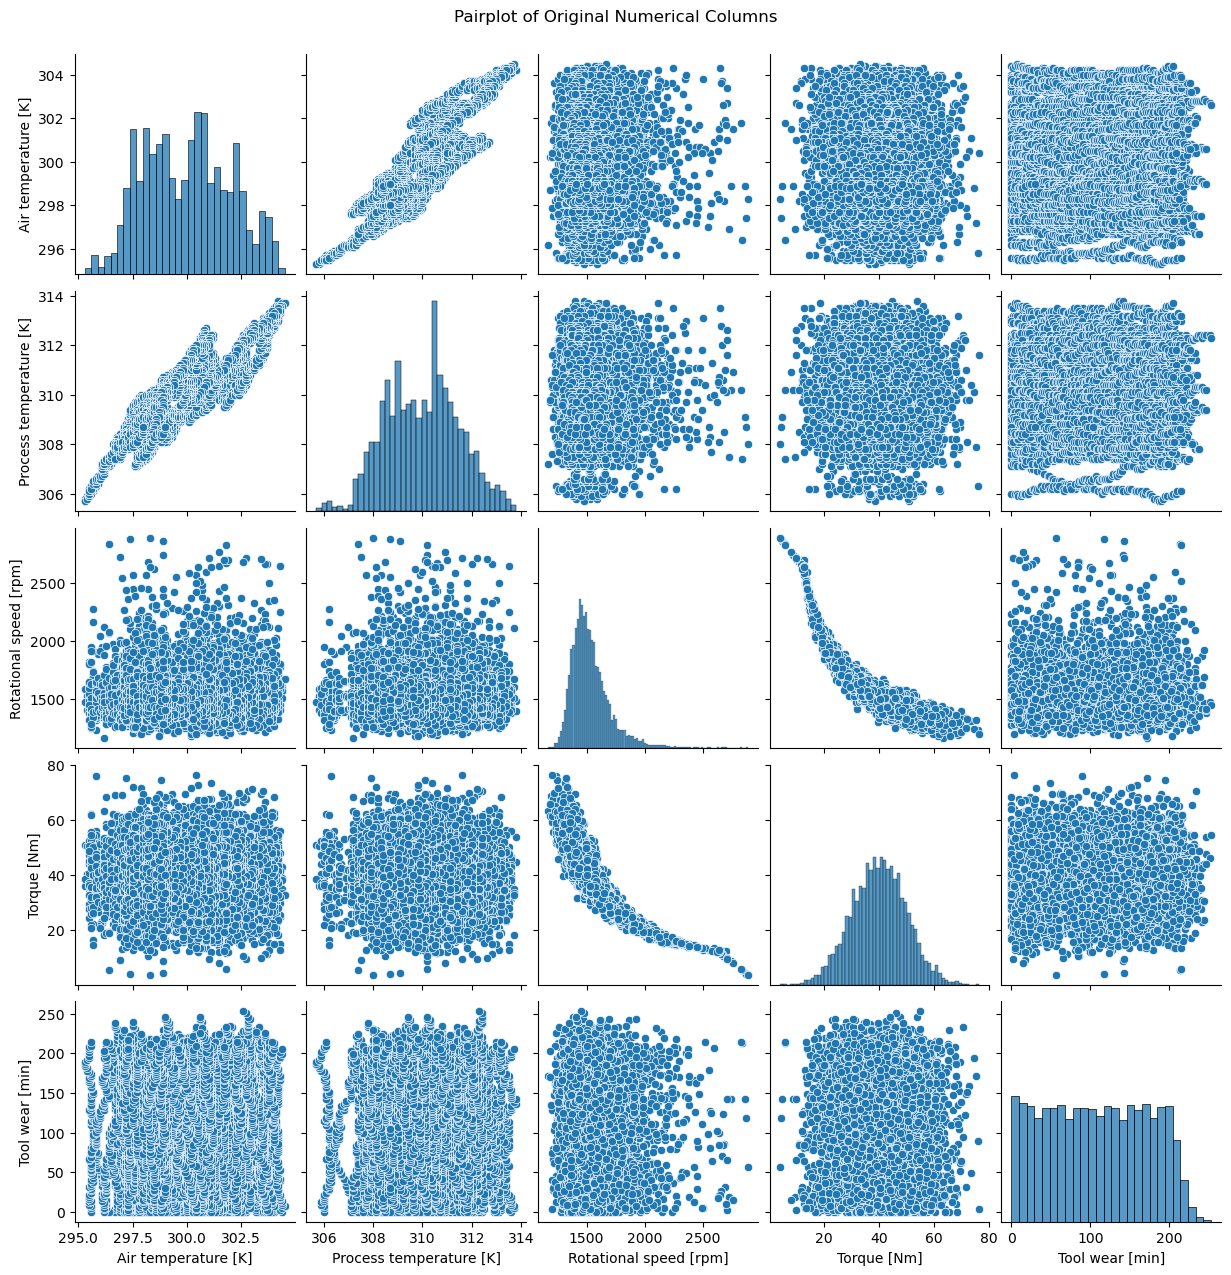

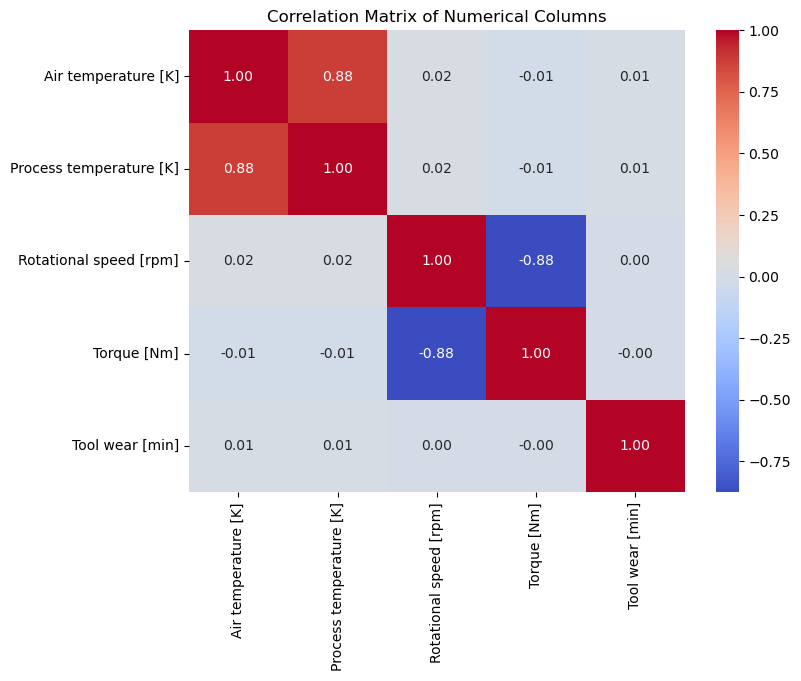

In [57]:
# Identify numerical columns (excluding binary columns)
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Pairplot of Original Numerical Columns
sns.pairplot(pred_df[numerical_cols])
plt.suptitle('Pairplot of Original Numerical Columns', y=1.02)
plt.show()

# Correlation Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pred_df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

## Processing

### 1. Let's drop `UDI` column

In [58]:
if 'UDI' in pred_df.columns:
    pred_df.drop('UDI', axis=1, inplace=True)
pred_df.head(80)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,L47255,L,298.8,308.9,1379,46.7,204,0,0,0,0,0,0
76,L47256,L,298.8,308.9,1461,47.9,206,0,0,0,0,0,0
77,L47257,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
78,L47258,L,298.8,308.9,1398,51.5,0,0,0,0,0,0,0


### 2. Given `Machine failure` column tracks machine status ( 0 or 1), combining failure types into a single column might be a good idea.
- Combine `TWF`, `HDF`, `PWF`, `OSF`, & `RNF` into a new column, `Failure type`, then drop the combined columns

In [59]:
# Combine failure types into a single column
pred_df_cleaned = pd.DataFrame(pred_df)
def combine_failures(row):
    failures = []
    if row['TWF']: failures.append('TWF')
    if row['HDF']: failures.append('HDF')
    if row['PWF']: failures.append('PWF')
    if row['OSF']: failures.append('OSF')
    if row['RNF']: failures.append('RNF')
    return ', '.join(failures) if failures else 'No Failure'

# Apply the function to each row
pred_df_cleaned['Failure type'] = pred_df.apply(combine_failures, axis=1)

# Dropping the original failure type columns
pred_df_cleaned.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

pred_df_cleaned.head(80)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...
75,L47255,L,298.8,308.9,1379,46.7,204,0,No Failure
76,L47256,L,298.8,308.9,1461,47.9,206,0,No Failure
77,L47257,L,298.8,308.9,1455,41.3,208,1,TWF
78,L47258,L,298.8,308.9,1398,51.5,0,0,No Failure


In [60]:
unbootstrapped_pred_df_cleaned = pred_df_cleaned.copy()
unbootstrapped_pred_df_cleaned.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## We earlier saw in the pairplot that the data isn't normalized. 

- Use `Bootstrapping` techniques to normalize the data

- Visualize the distribution

In [61]:
def bootstrap_resample(data, n_bootstrap=1000):
    """Perform bootstrapping on the data and return the sample means."""
    bootstrap_means = np.zeros(n_bootstrap)
    n = len(data)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means[i] = np.mean(sample)
    return bootstrap_means

In [62]:
# Columns to bootstrap
columns_to_bootstrap = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Initialize a dictionary to hold bootstrapped means for each column
bootstrap_results = {}

# Perform bootstrapping for each column
for column in columns_to_bootstrap:
    bootstrap_means = bootstrap_resample(pred_df_cleaned[column])
    bootstrap_results[column] = bootstrap_means



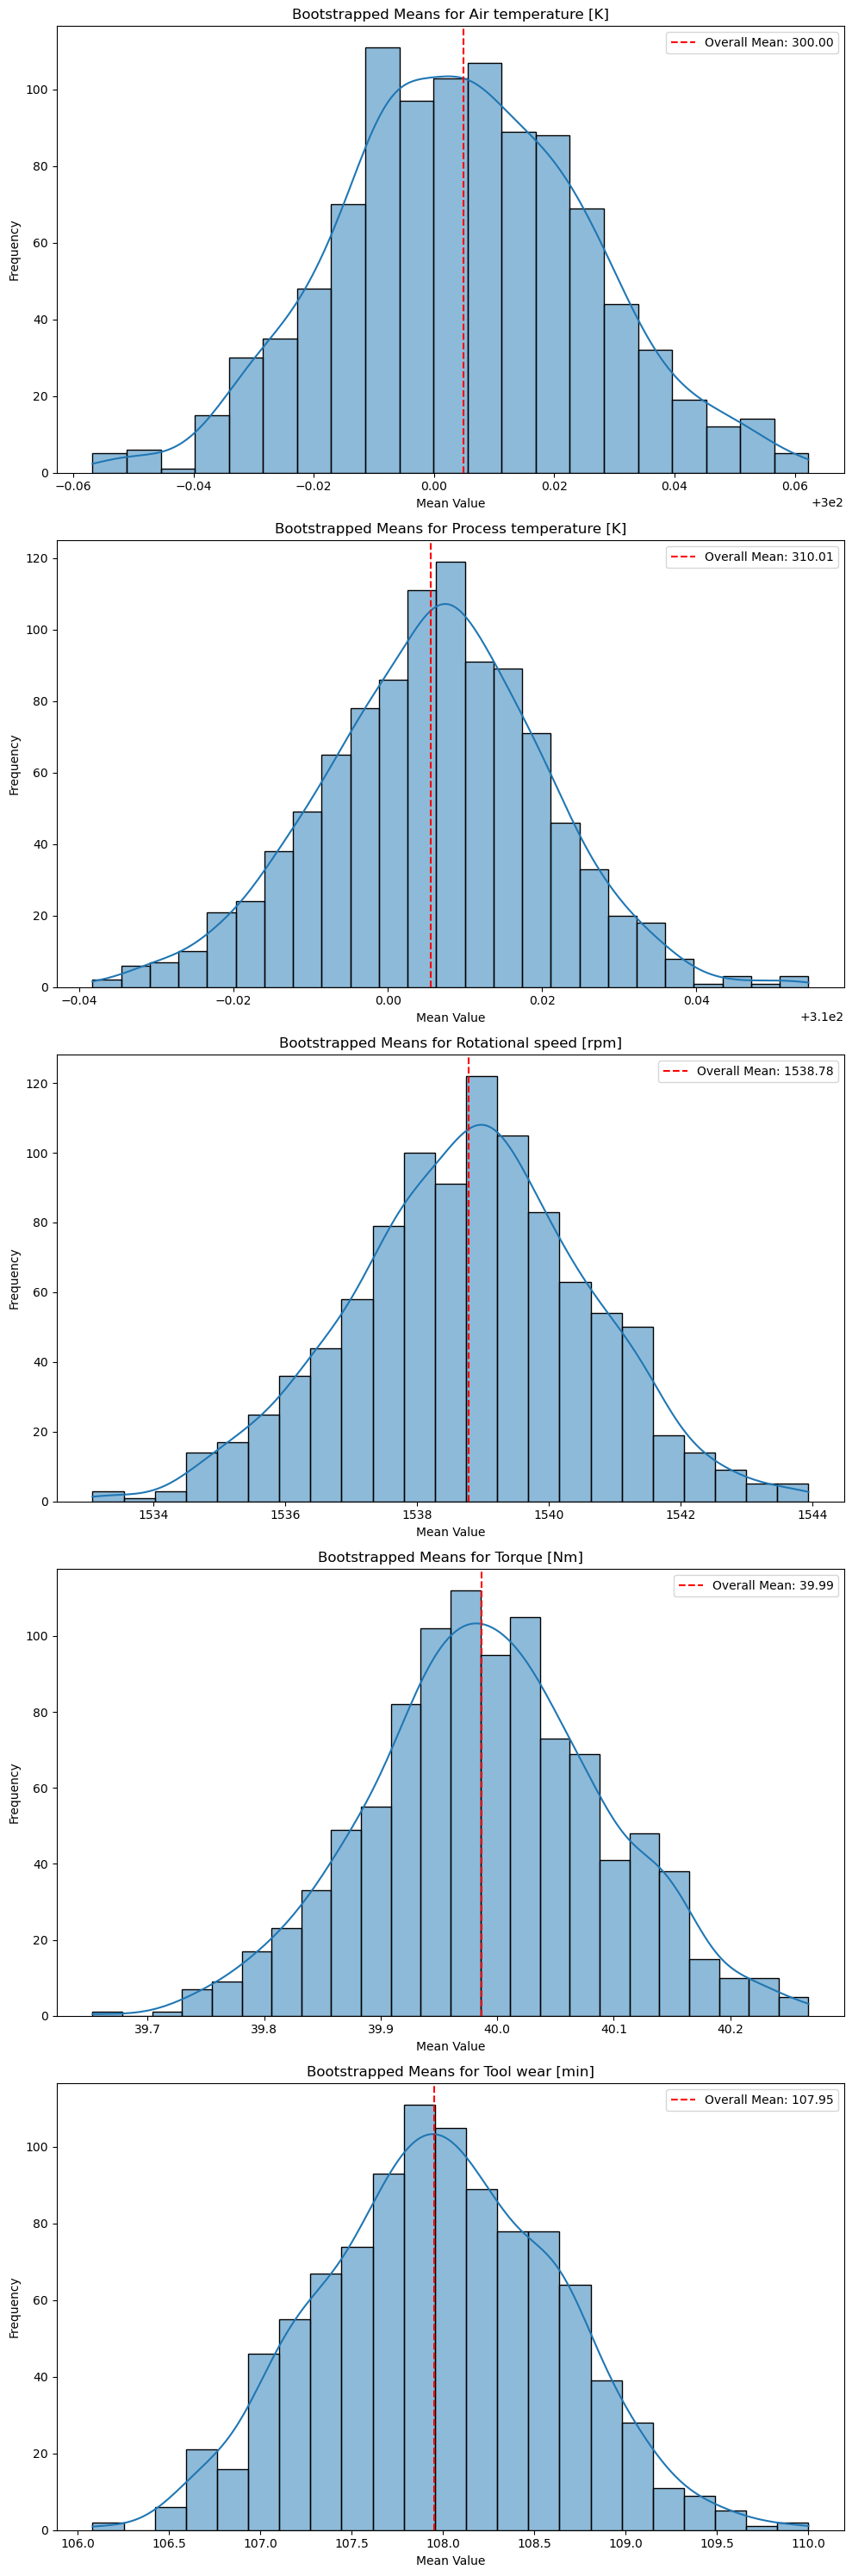

In [63]:
# Visualization with axlines for overall means
fig, axs = plt.subplots(len(columns_to_bootstrap), 1, figsize=(10, 6 * len(columns_to_bootstrap)))

for i, column in enumerate(columns_to_bootstrap):
    overall_mean = pred_df_cleaned[column].mean()  # Calculate the overall mean for the column
    sns.histplot(bootstrap_results[column], kde=True, ax=axs[i])
    axs[i].axvline(overall_mean, color='r', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
    axs[i].set_title(f'Bootstrapped Means for {column}')
    axs[i].set_xlabel('Mean Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

plt.tight_layout()
plt.show()

## Question:

Given the operational parameters and machine states available in the dataset, can we identify patterns or conditions indicative of an impending failure?

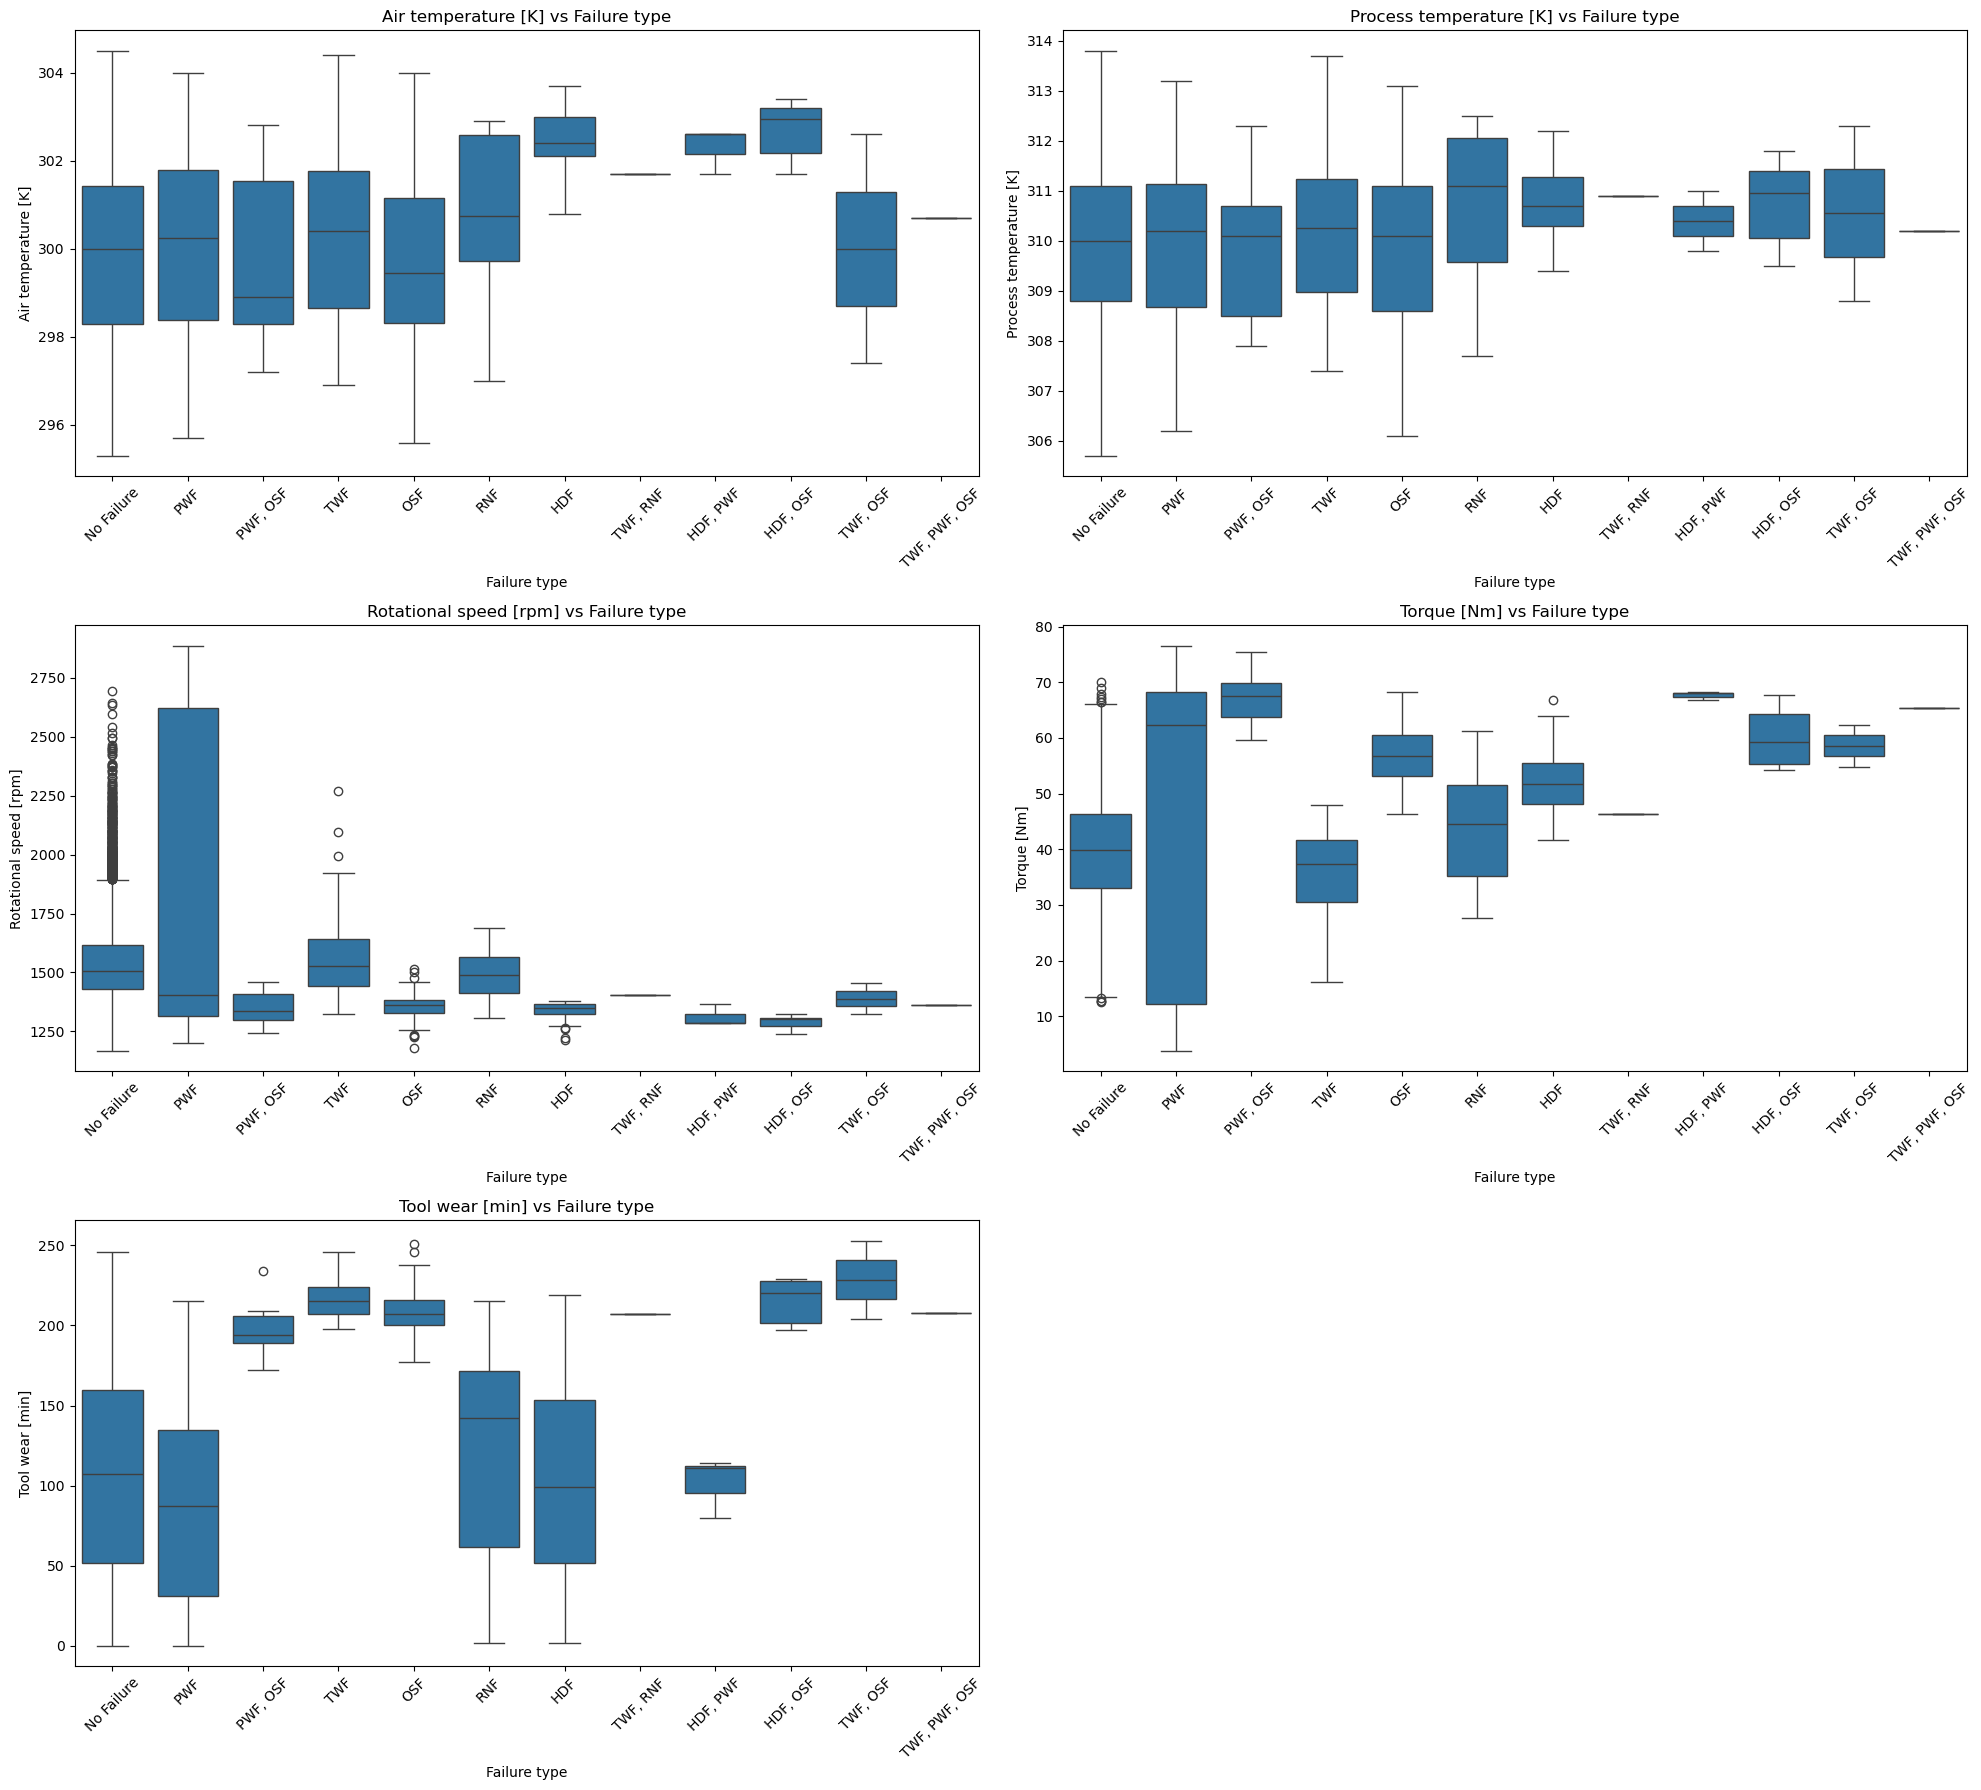

In [64]:
# Initialize the subplot
fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # Adjusting for 5 plots, will leave one empty
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Iterate through each operational parameter to create boxplots
for i, column in enumerate(['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']):
    sns.boxplot(x='Failure type', y=column, data=pred_df_cleaned, ax=axes[i])
    axes[i].set_title(f'{column} vs Failure type')
    axes[i].tick_params(axis='x', rotation=45)

# Remove the last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [65]:
# Get the min and max values for each ops parameter
min_max_values = pred_df_cleaned[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].agg(['min', 'max'])
min_max_values

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
min,295.3,305.7,1168,3.8,0
max,304.5,313.8,2886,76.6,253


In [66]:
pred_df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


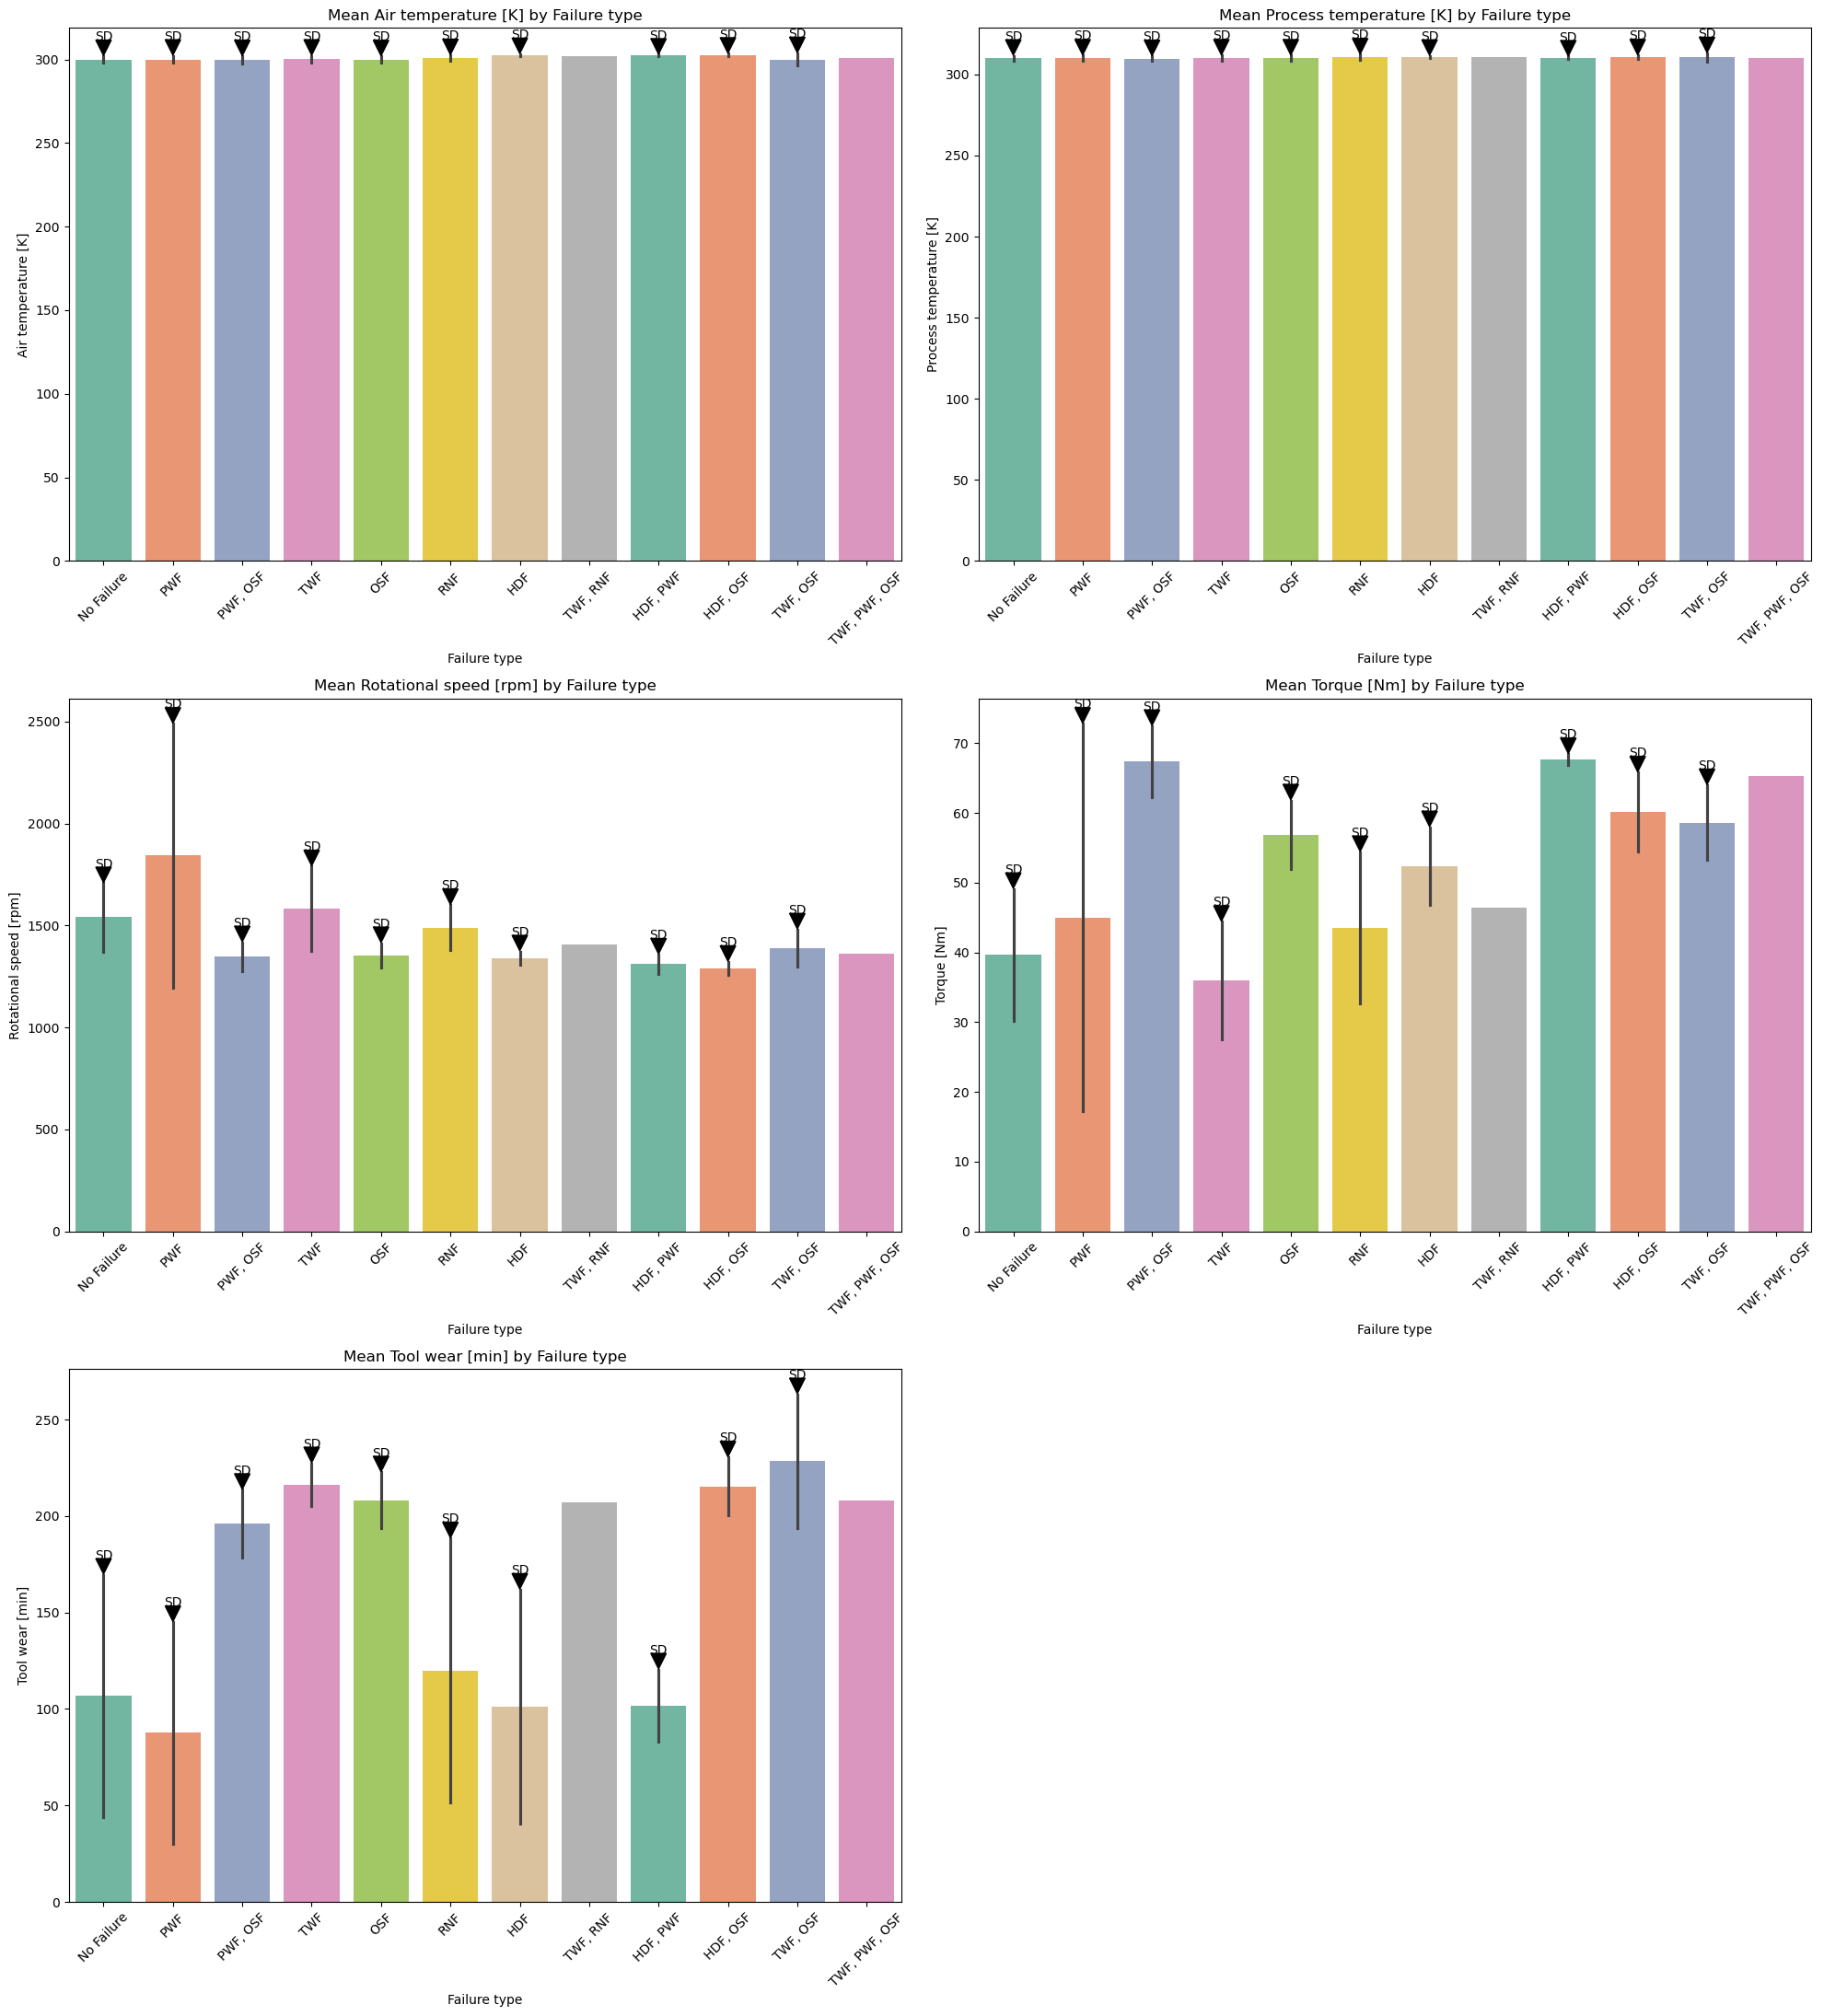

In [67]:
# Initialize the subplot
fig, axes = plt.subplots(3, 2, figsize=(20, 22))  
axes = axes.flatten()  # For easy iteration

# Iterate through each operational parameter to create bar plots
for i, column in enumerate(['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']):
    
    # Create the bar plot
    sns.barplot(x='Failure type', y=column, hue='Failure type', data=pred_df_cleaned, ax=axes[i], palette='Set2', errorbar='sd', legend=False)
    axes[i].set_title(f'Mean {column} by Failure type')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Calculate mean and standard deviation for annotations
    for failure_type in pred_df_cleaned['Failure type'].unique():
        subset = pred_df_cleaned[pred_df_cleaned['Failure type'] == failure_type]
        mean = subset[column].mean()
        sd = subset[column].std()
        
        # Annotate error bar per subplot
        axes[i].annotate('SD', xy=(failure_type, mean + sd), xytext=(0, 10),
                         textcoords='offset points', ha='center', va='bottom',
                         arrowprops=dict(facecolor='black', shrink=0.05))

# Remove the last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### Findings:
- `Air temperature [K]`: It might be ideal to convert from Kelvin to Celcius and compare results
- `Process temperature [K]`: Likewise, convert from K to C
- `Rotational speed [rpm]`: We can identify some patterns with `PWF (power failure)` being the common when rotational speed is higher than normal
- `Torque [Nm]`: Torque of `~40 Nm (Newton-meters)` appears to be the normal with extreme lows and highs leading to machine failure
- `Tool wear [min]`: On average, 100 minutes is the duration before failure of certain type occurs.


### Let's convert values `Temperature' columns to Celcius from Kelvin

In [68]:
# Create a copy of pred_df_cleaned to preserve the original data
pred_df_cleaned_celcius = pred_df_cleaned.copy()

# Convert temperatures from Kelvin to Celsius
pred_df_cleaned_celcius['Air temperature [C]'] = pred_df_cleaned_celcius['Air temperature [K]'] - 273.15
pred_df_cleaned_celcius['Process temperature [C]'] = pred_df_cleaned_celcius['Process temperature [K]'] - 273.15

# Define the new column order, replacing Kelvin columns with Celsius columns
new_column_order = ['Product ID', 'Type', 'Air temperature [C]', 'Process temperature [C]',
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
                    'Machine failure', 'Failure type']

# Reorder the DataFrame according to the new column order
pred_df_cleaned_celcius = pred_df_cleaned_celcius[new_column_order]

# Display the first few rows of the reordered DataFrame
pred_df_cleaned_celcius.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M14860,M,24.95,35.45,1551,42.8,0,0,No Failure
1,L47181,L,25.05,35.55,1408,46.3,3,0,No Failure
2,L47182,L,24.95,35.35,1498,49.4,5,0,No Failure
3,L47183,L,25.05,35.45,1433,39.5,7,0,No Failure
4,L47184,L,25.05,35.55,1408,40.0,9,0,No Failure


### Replot using the converted values.

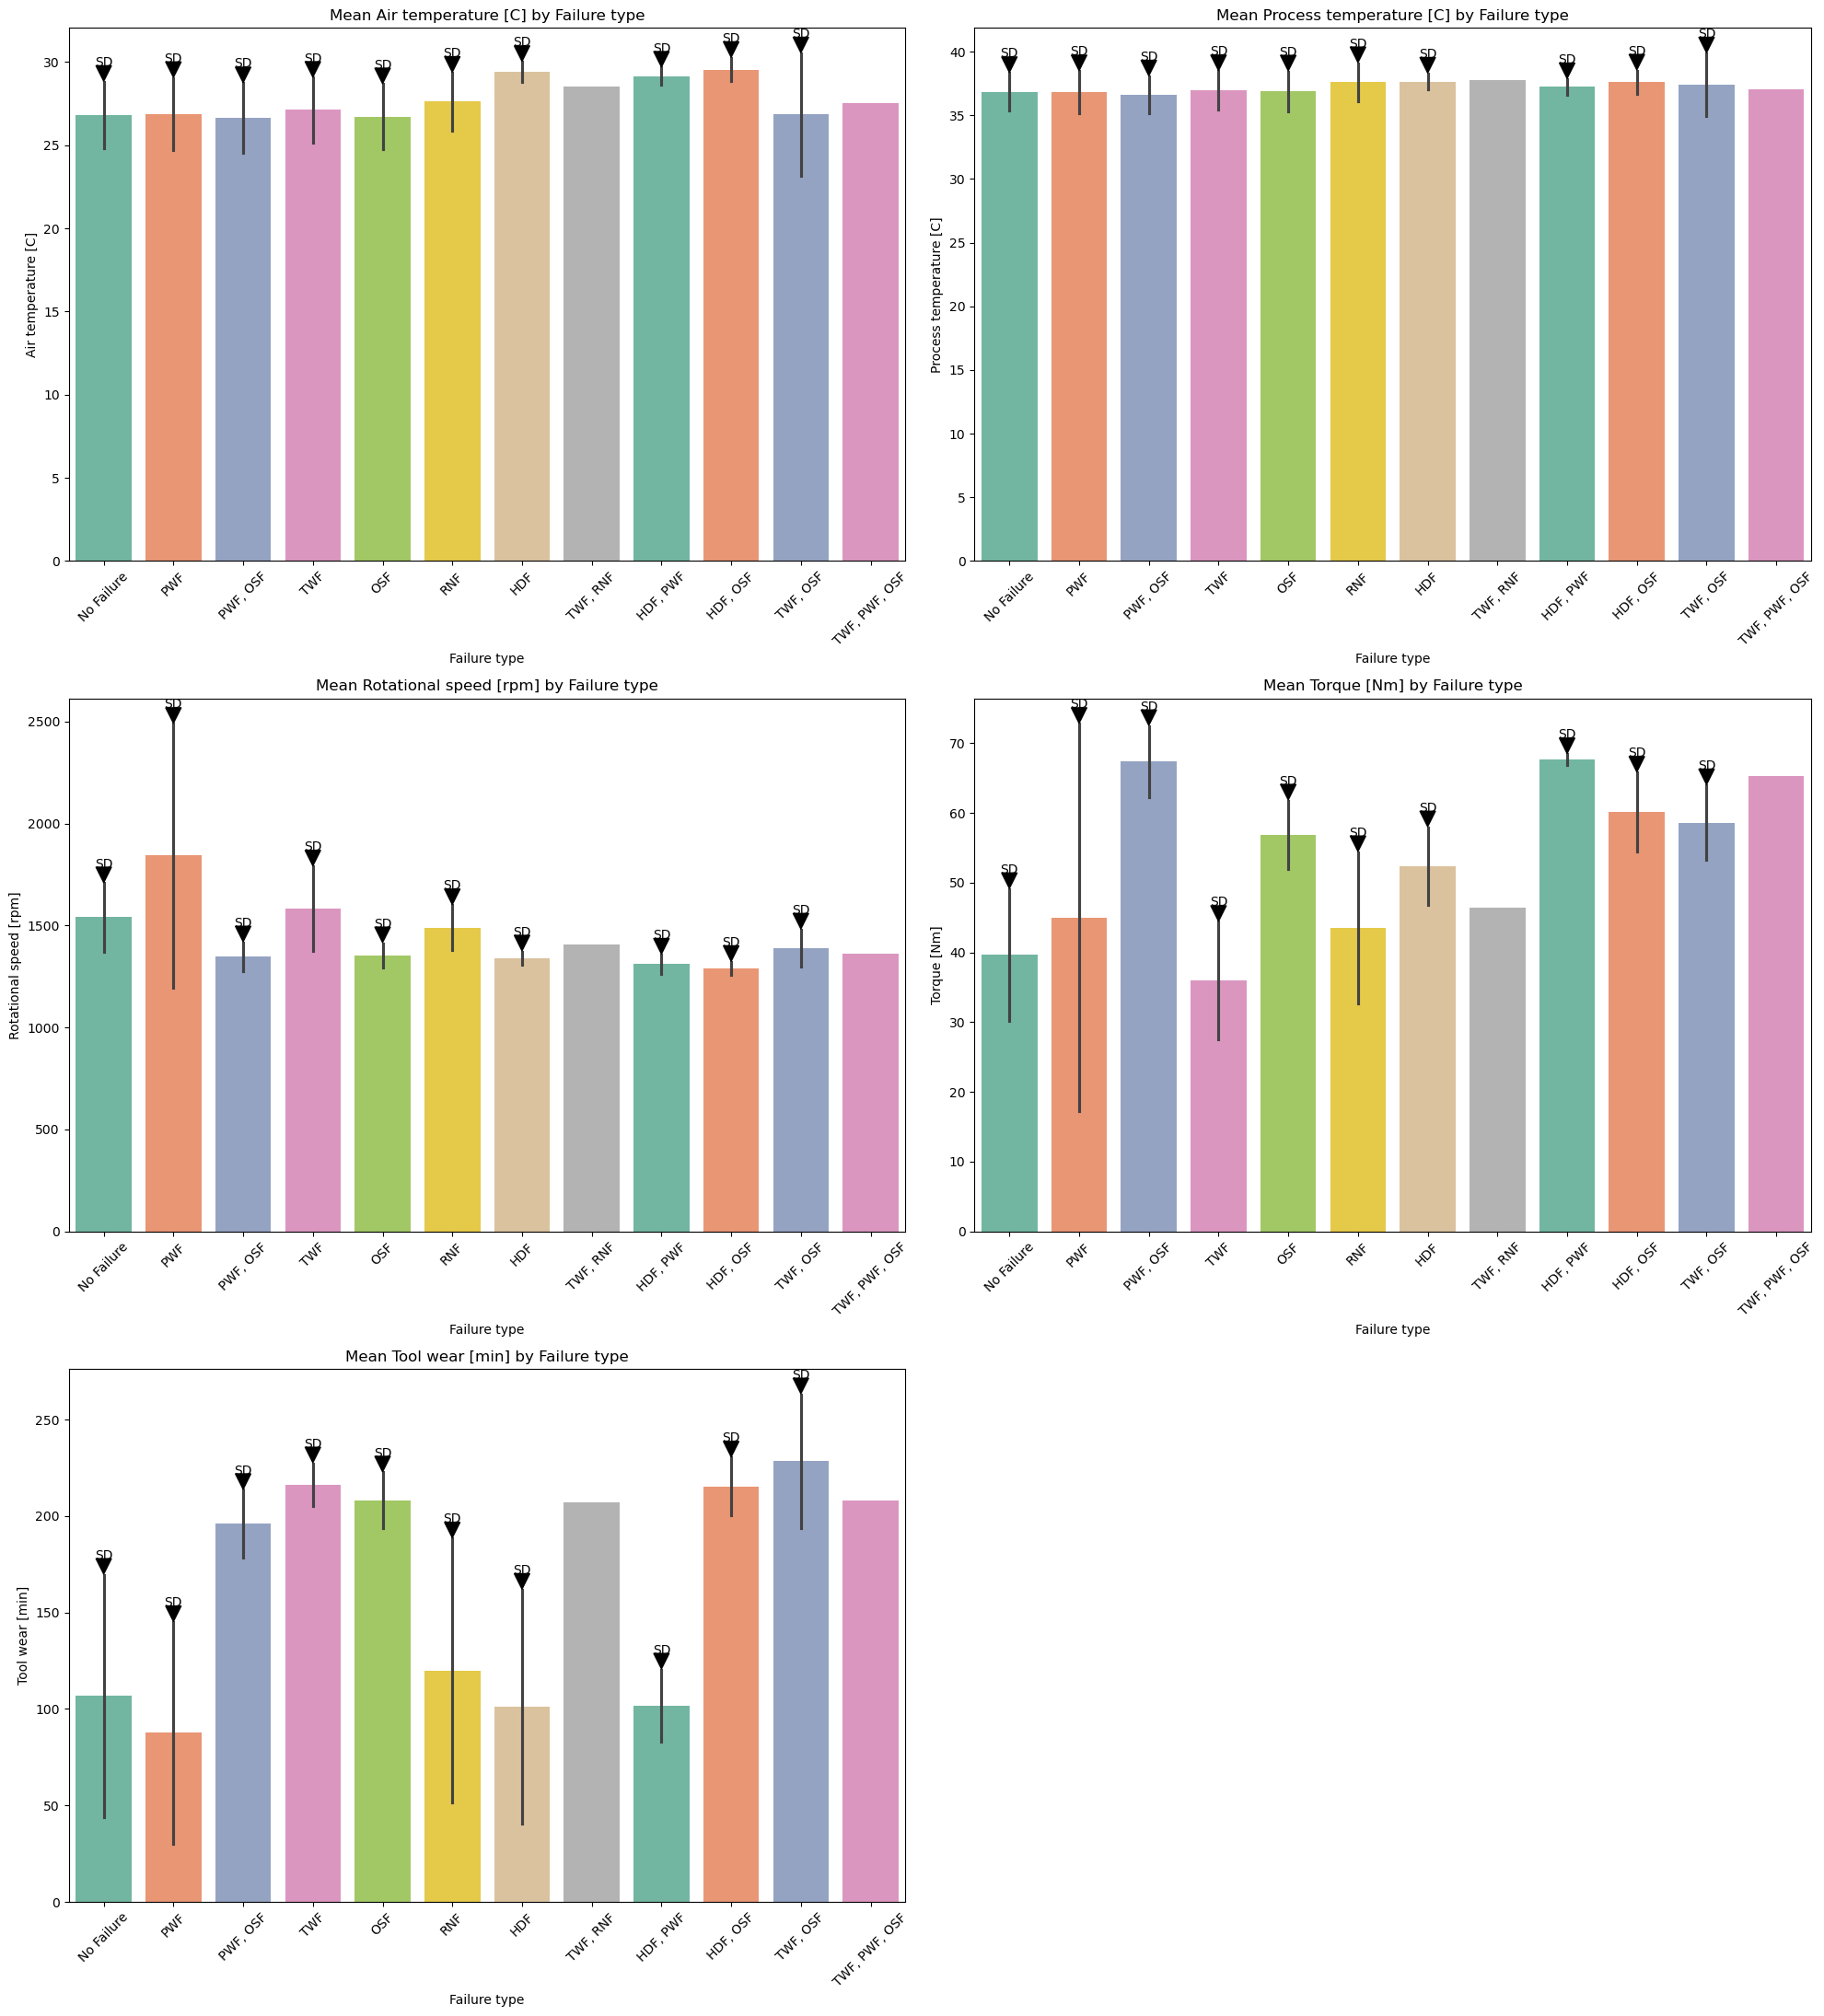

In [69]:

# Initialize the subplot
fig, axes = plt.subplots(3, 2, figsize=(20, 22))  
axes = axes.flatten()  # For easy iteration

# Iterate through each operational parameter to create bar plots
for i, column in enumerate(['Air temperature [C]', 'Process temperature [C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']):
    
    # Create the bar plot
    sns.barplot(x='Failure type', y=column, hue='Failure type', data=pred_df_cleaned_celcius, ax=axes[i], palette='Set2', errorbar='sd', legend=False)
    axes[i].set_title(f'Mean {column} by Failure type')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Calculate mean and standard deviation for annotations
    for failure_type in pred_df_cleaned_celcius['Failure type'].unique():
        subset = pred_df_cleaned_celcius[pred_df_cleaned_celcius['Failure type'] == failure_type]
        mean = subset[column].mean()
        sd = subset[column].std()
        
        # Annotate error bar per subplot
        axes[i].annotate('SD', xy=(failure_type, mean + sd), xytext=(0, 10),
                         textcoords='offset points', ha='center', va='bottom',
                         arrowprops=dict(facecolor='black', shrink=0.05))

# Remove the last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

**Findings**:
- `Air temperature [K]`: Slight variation on machine temperature seems to correlate with most of failure types
- `Process temperature [K]`: Process temperature appears to be having minimal effect on failure types if visualized using a bar plot.

### Let's try plotting in a histogram

### Plot distribution of machine failure across all parameters


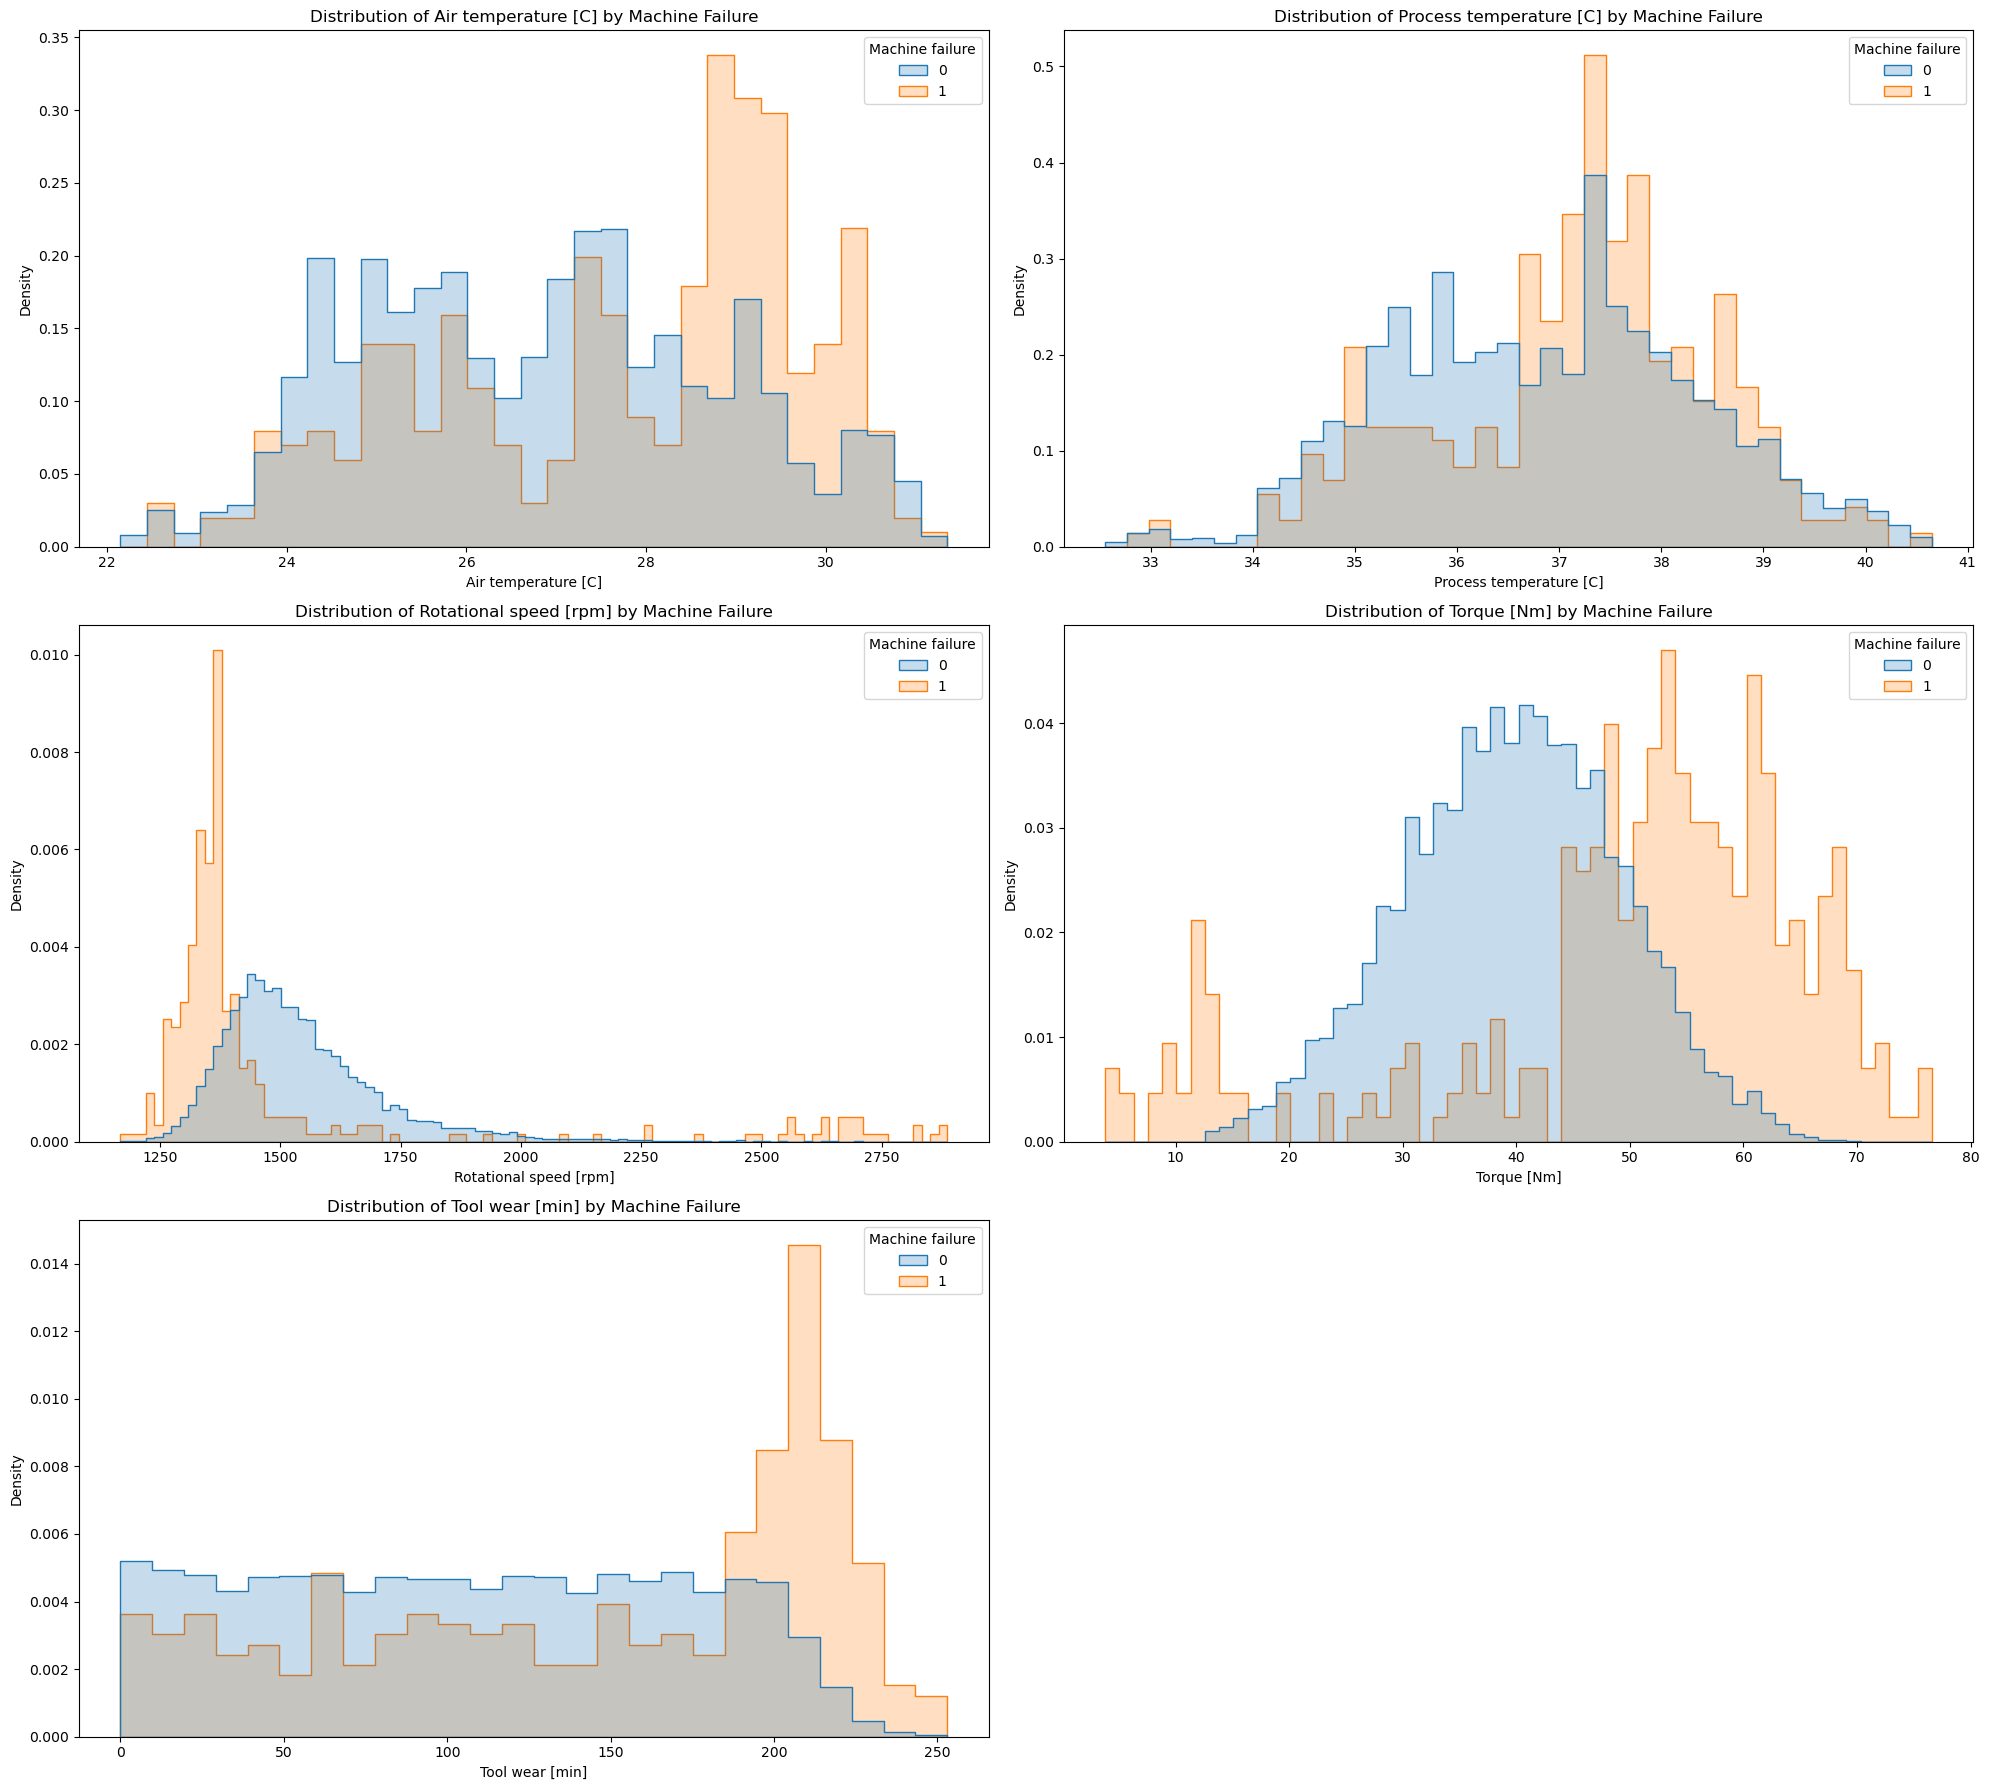

In [70]:
columns_to_plot = ['Air temperature [C]', 'Process temperature [C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Loop and plot
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=pred_df_cleaned_celcius, x=column, hue='Machine failure', element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {column} by Machine Failure')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')

# Remove the last empty subplot
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [71]:
pred_df_cleaned_celcius.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M14860,M,24.95,35.45,1551,42.8,0,0,No Failure
1,L47181,L,25.05,35.55,1408,46.3,3,0,No Failure
2,L47182,L,24.95,35.35,1498,49.4,5,0,No Failure
3,L47183,L,25.05,35.45,1433,39.5,7,0,No Failure
4,L47184,L,25.05,35.55,1408,40.0,9,0,No Failure


### Plot distribution of failure types across all parameters

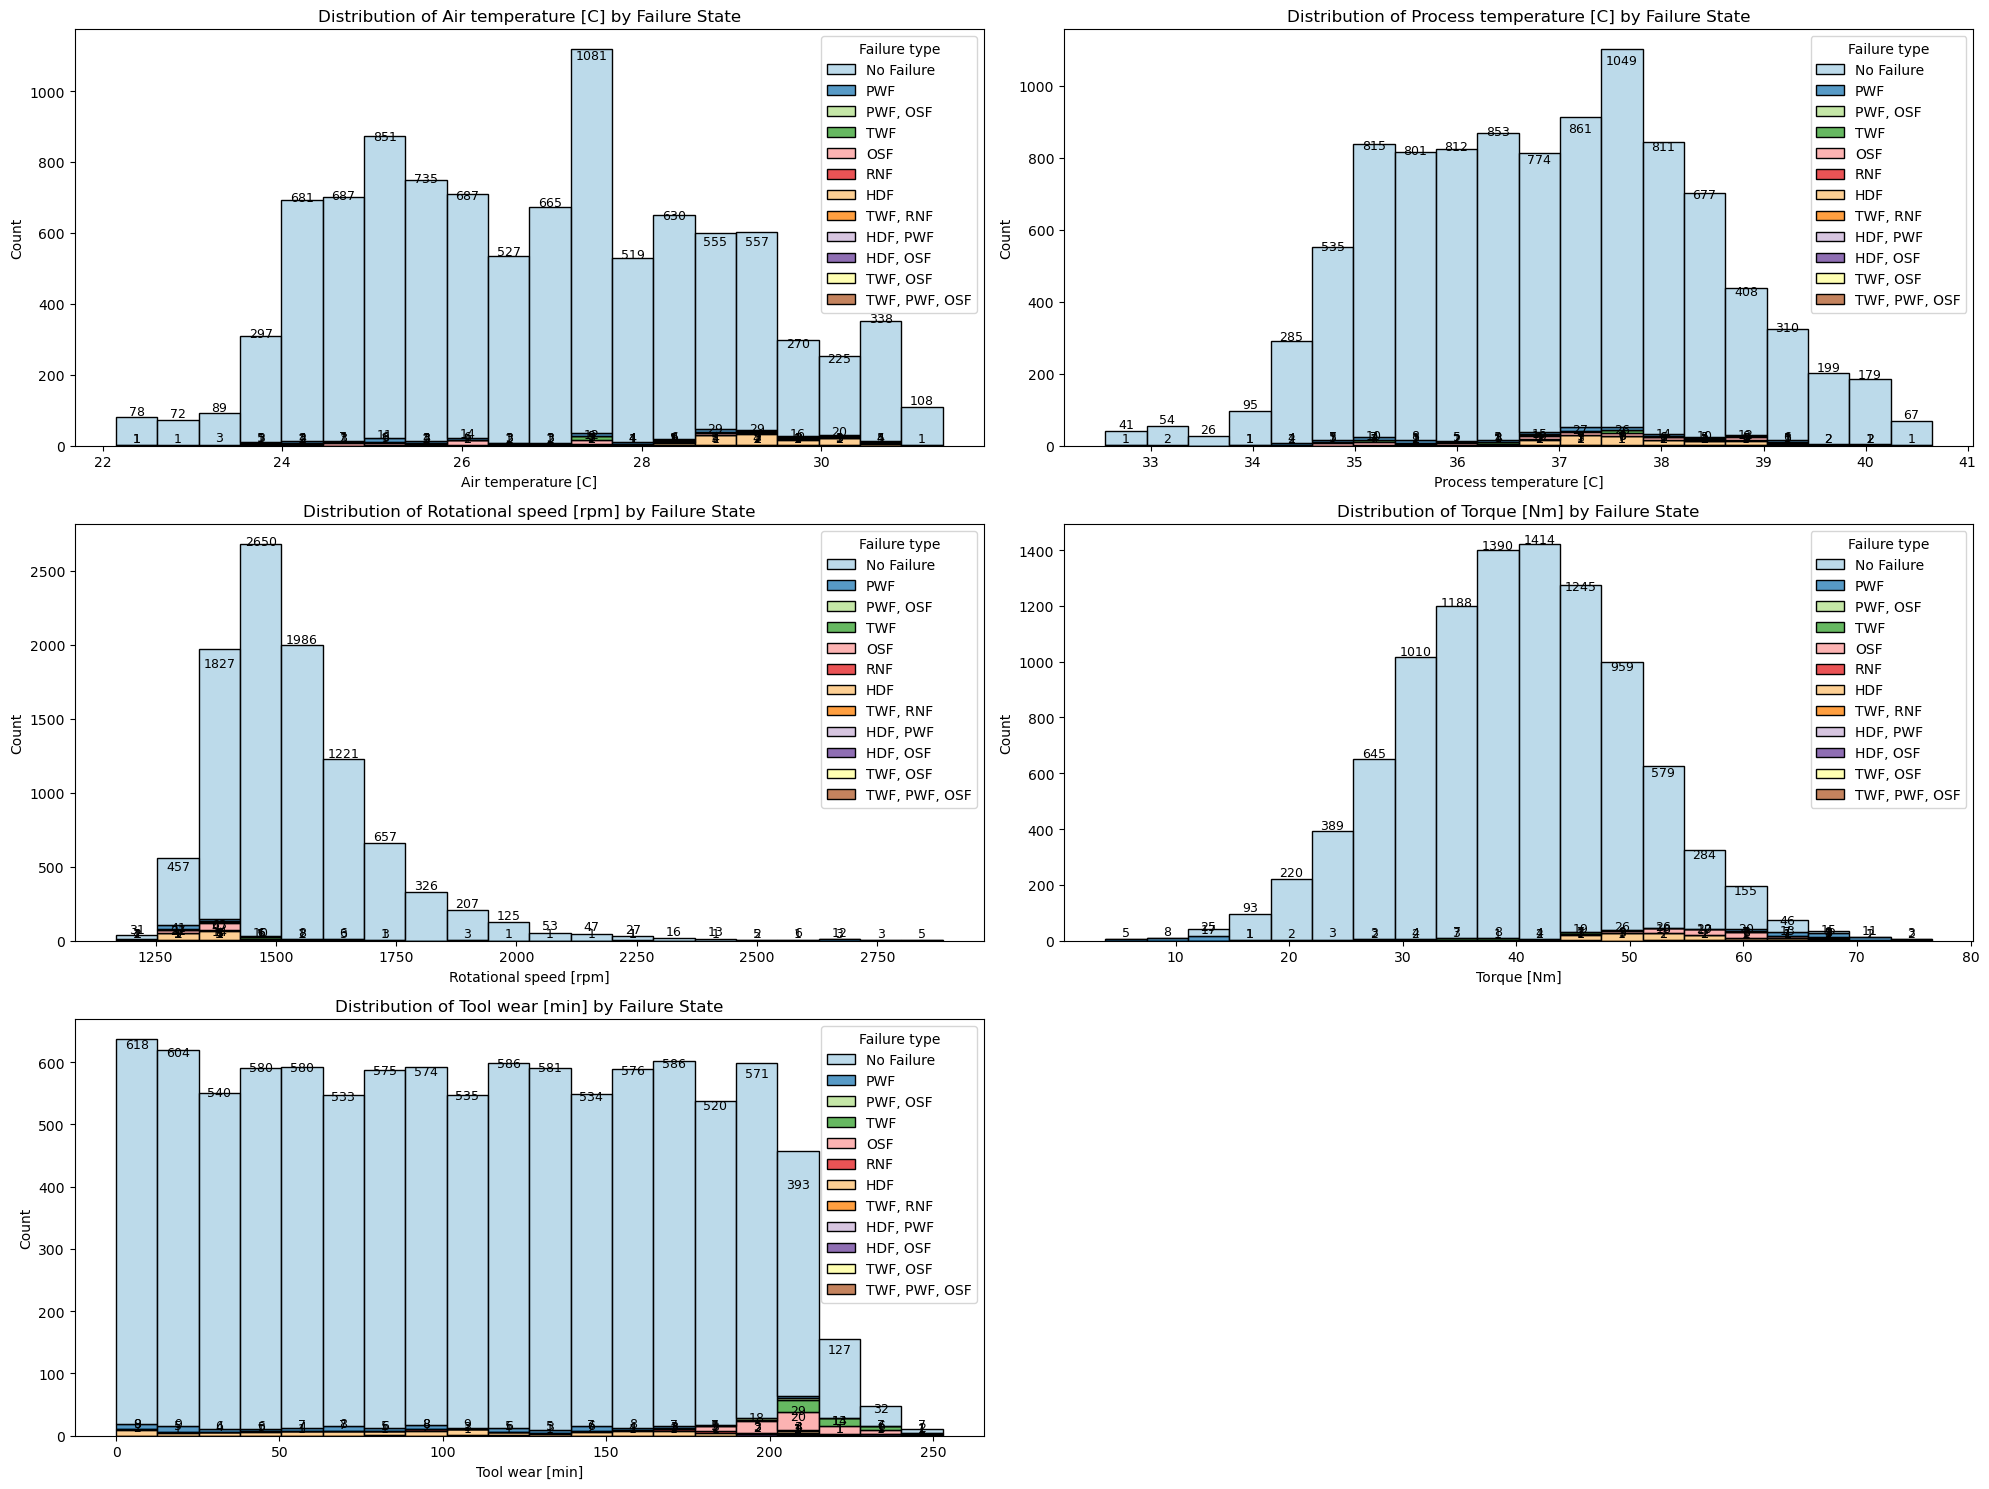

In [72]:
# Setup for subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

# Define a custom palette
base_palette = sns.color_palette('Paired')
custom_palette = {failure_type: color for failure_type, color in zip(pred_df_cleaned_celcius['Failure type'].unique(), base_palette)}

# Iterate through each operational parameter to create histograms
for i, column in enumerate(columns_to_plot):
    # Corrected binrange to be specific for each column
    ax = sns.histplot(data=pred_df_cleaned_celcius, x=column, hue='Failure type', multiple="stack", palette=custom_palette, ax=axes[i], binrange=(pred_df_cleaned_celcius[column].min(), pred_df_cleaned_celcius[column].max()), bins=20)
    axes[i].set_title(f'Distribution of {column} by Failure State')

    # Annotating counts on each bin
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate non-zero bins
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')

# Remove the last empty subplot if necessary
if len(columns_to_plot) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

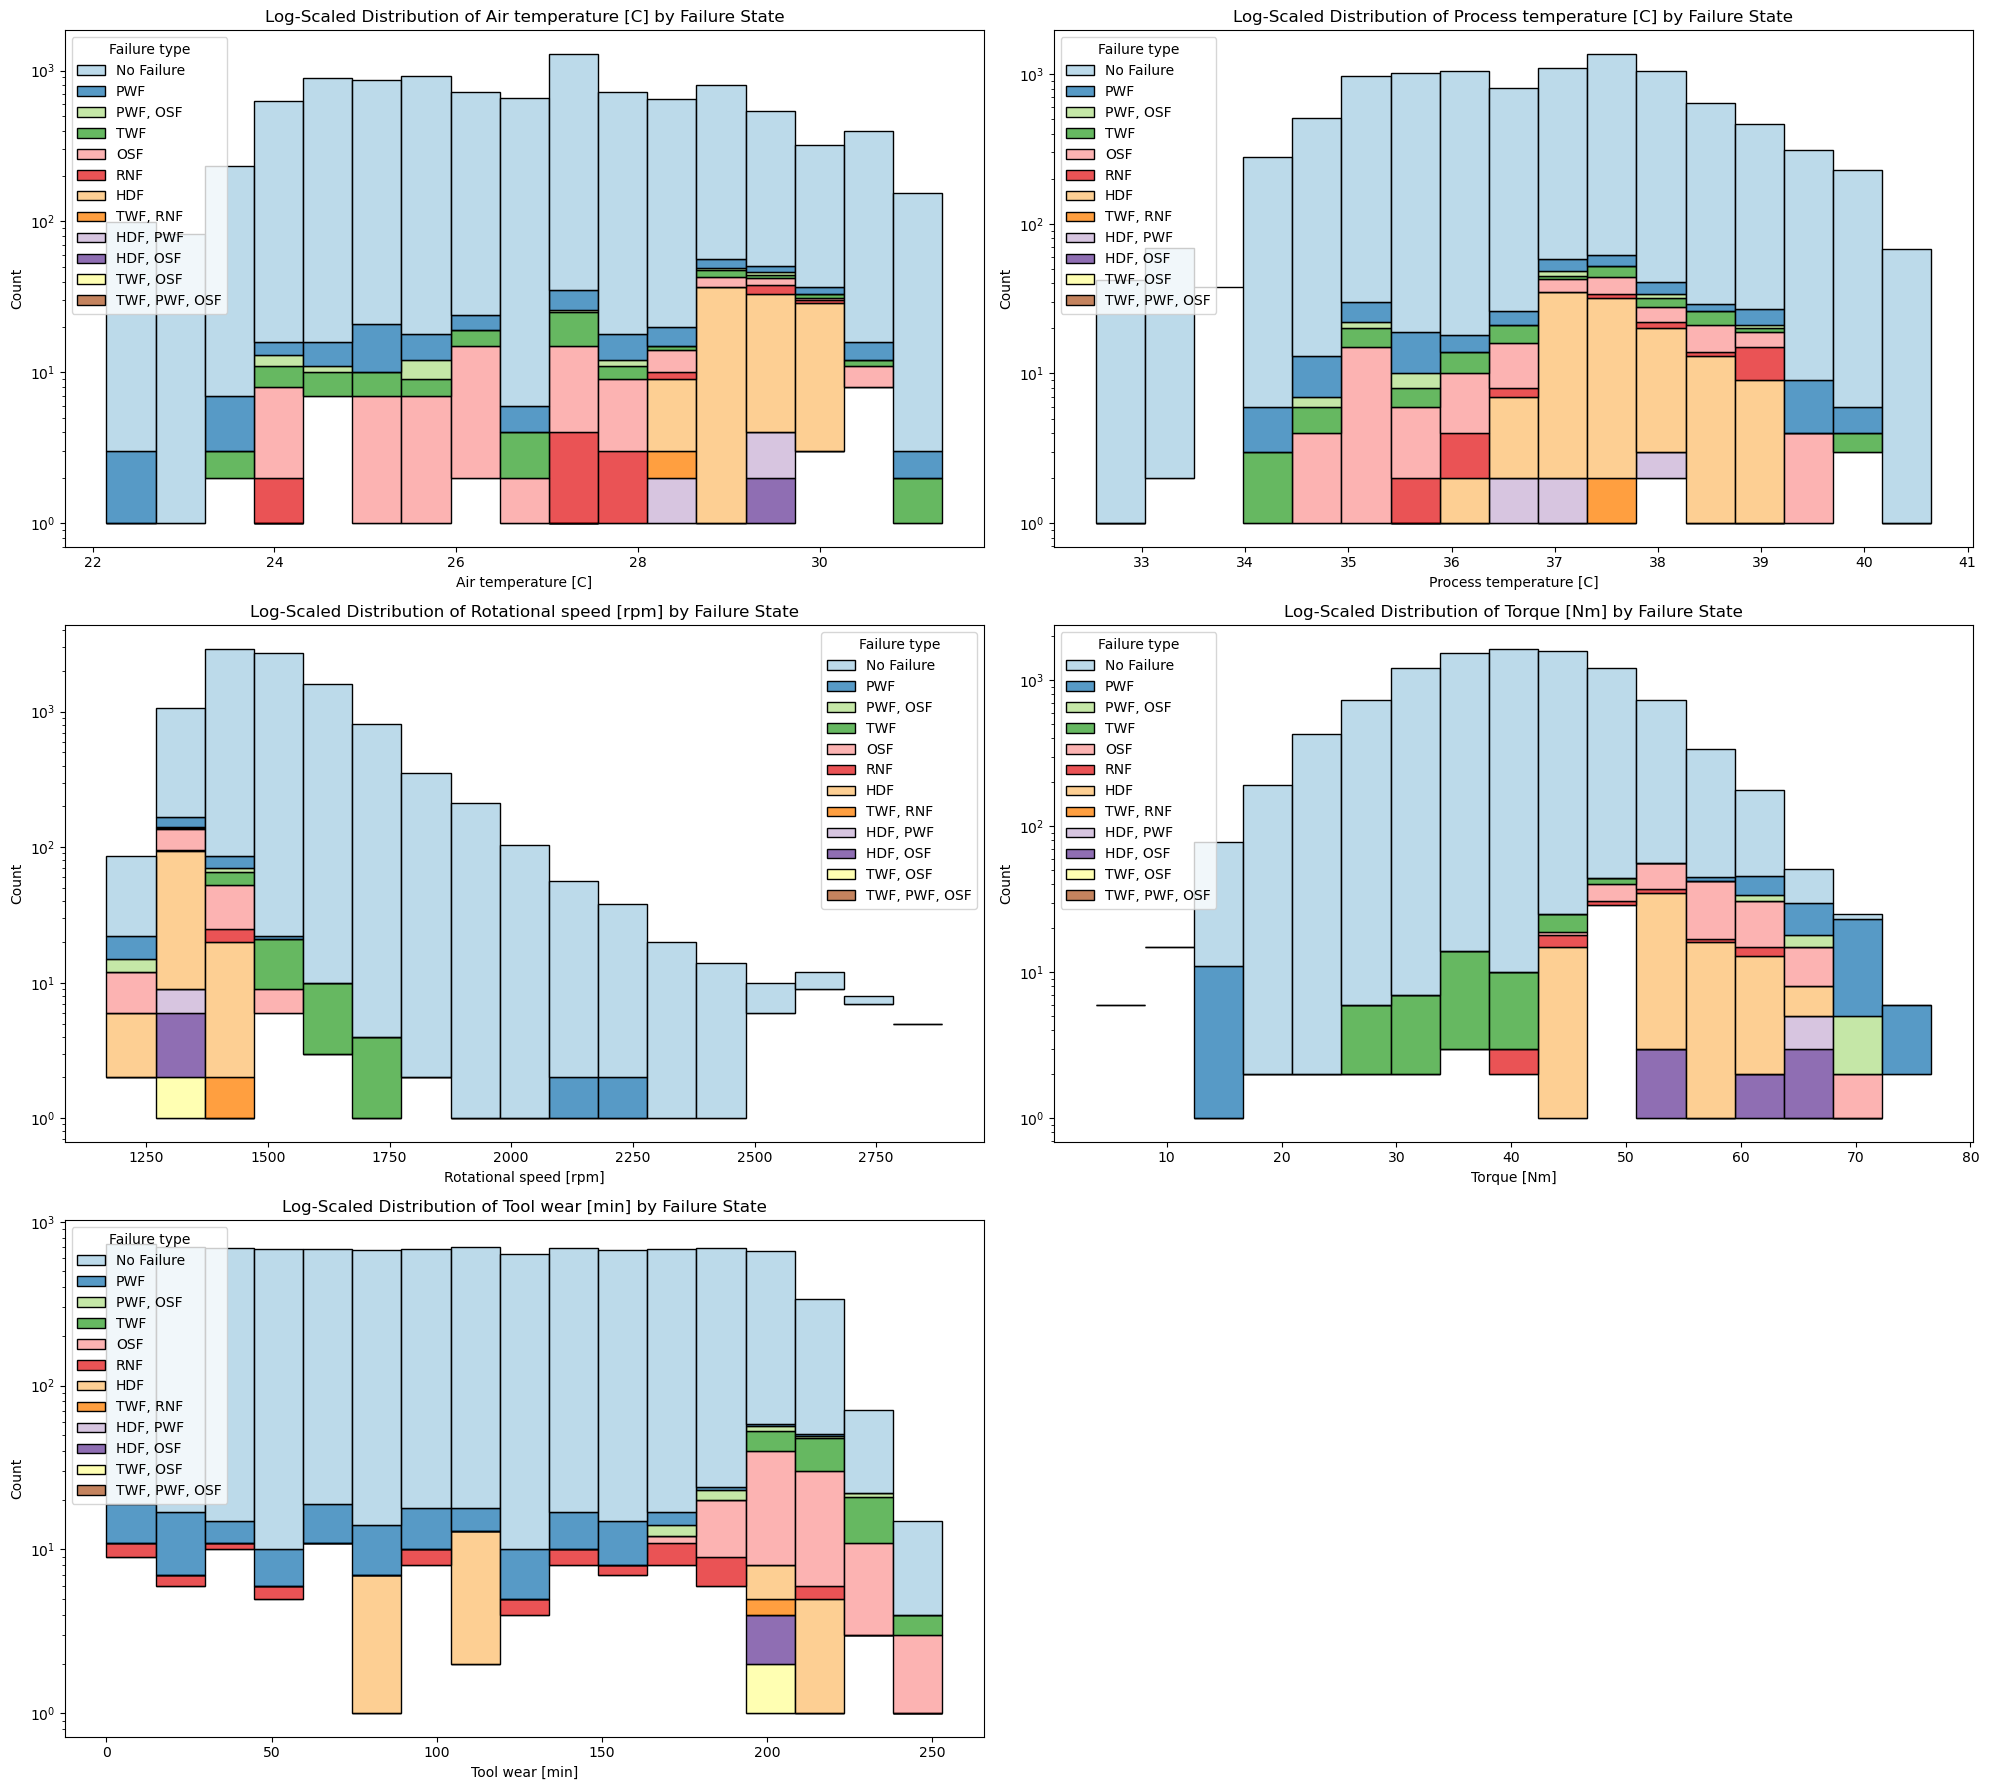

In [73]:
n_cols = 2
n_rows = (len(columns_to_plot) + 1) // n_cols

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Iterate through each operational parameter to create histograms
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=pred_df_cleaned_celcius, x=column, hue='Failure type', multiple="stack", kde=False, palette=custom_palette, bins=17, log_scale=(False, True), ax=axes[i])
    axes[i].set_title(f'Log-Scaled Distribution of {column} by Failure State')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()